In [1]:
import matplotlib.pyplot as plt
from mpi4py import MPI
from petsc4py.PETSc import ScalarType 
import numpy as np
from matplotlib.font_manager import FontProperties

import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem import assemble_scalar, form
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner

## This link is super super helpful!!!
## https://paulpotgieter.org/2023/04/17/installing-fenics-to-run-with-jupyter-notebook/
##########################################################################################
#### https://fenics.readthedocs.io/projects/containers/en/latest/jupyter.html ##########
##########################################################################################
# New opening up options ####
# docker run --rm -ti -v $(pwd):/root/shared -w /root/shared --init -ti -p 8888:8888 dolfinx/lab:stable


In [2]:
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (1.0, 1.0)), n=(32, 32),
                            cell_type=mesh.CellType.triangle)
V = fem.functionspace(msh, ("Lagrange", 1))

In [3]:
facets = mesh.locate_entities_boundary(msh, dim=(msh.topology.dim - 1),
                                       marker=lambda x: np.logical_or.reduce((
                                           np.isclose(x[0], 0.0),
                                           np.isclose(x[0], 1.0),
                                           np.isclose(x[1], 0.0),
                                           np.isclose(x[1], 1.0))))
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

In [4]:
# create boundary points, starting from (0,0), clockwise
n = 11;
x = np.linspace(0, 1, n)
c = np.zeros((4*n-4,2))
c[n:2*n-1,0] = x[1:]
c[2*n-1:3*n-3,0] = 1
c[3*n-3:,0] = np.flip(x[1:],axis = 0)
c[0:n,1] = x
c[n:2*n-2,1] = 1
c[2*n-2:3*n-3,1] = np.flip(x[1:],axis = 0)
# c
# plt.scatter(c[:,0], c[:,1]) 

In [5]:
###  The source/receiver functions near the boundaries
#### Note these f is the source term belonging to the weaker space
f_all = []
for i in range(40):
    f = fem.Function(V)
    f.interpolate(lambda x: np.exp(-(pow(x[0] - c[i,0] ,2)+pow(x[1] - c[i,1],2))*20) )
    f_all.append(f)


In [6]:
u_trial = ufl.TrialFunction(V)
u_test = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)

# atrue = ufl.sin(x[0])**2 + ufl.sin(x[1])**2 + ufl.sin(10*x[0])**2 + ufl.sin(10*x[1])**2  

# atrue = fem.Function(V)
# atrue.interpolate(lambda x: 1 + ( (x[0]-0.5)**2 + (x[1] - 0.5)**2 < 0.01) + \
#                                 (pow(np.sin(x[0]*10),2) + pow(np.sin(x[1]*10),2)))
atrue = 30*(ufl.sin(x[0]*3)**2 + ufl.sin(x[1]*3)**2 \
          + ufl.sin(10*x[0])**2 + ufl.sin(10*x[1])**2 ) 


In [7]:
# obtain p_i's from f_i's
## Note that p_i is the Riesz representation of f_i based on a_true!!!
p_all = []
B = inner(grad(u_trial),grad(u_test))*dx + inner(atrue*u_trial,u_test)*dx 
for i in range(40):
    RHS = f_all[i] * u_test * dx
    problem = LinearProblem(B, RHS, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    u = problem.solve()
    p_all.append(u)

In [8]:
# The bilinear form
# \mathcal{A}_c(u,v)=\int_{\Omega} \nabla u(x)\cdot \nabla v(x)\mathrm{d}x + ...
# \int_{\Omega} c(x)u(x)v(x)\mathrm{d}x - \lambda \int_{\Omega} u(x)v(x)\mathrm{d}x

l = 100
A = inner(grad(u_trial),grad(u_test))*dx \
    + inner(atrue*u_trial,u_test)*dx \
    - inner(l*u_test, u_trial)*dx

w_all = [] # initialize {w_i}
D = np.zeros((40,40))
for j in range(40):
    L_true = f_all[j] * u_test * dx
    # solve the forward/state problem to generate synthetic observations
    problem = LinearProblem(A, L_true, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    u_j = problem.solve()
    w_all.append(u_j)
    
    for i in range(40):
        # d_{ij} = \mathcal{P}_i(u_j) = \langle p_i, u_j(\lambda)\rangle_\mathsf{U}
        # The inner product
        # \langle u,v\rangle_{\mathsf{U}} = \int_{\Omega} \nabla u(x)\cdot\nabla v(x)\mathrm{d}x
        #                                    + \int_{\Omega} c(x)u(x)v(x)\mathrm{d}x
        
        D[i,j] = assemble_scalar(form(inner(grad(u_j),grad(p_all[i]))*dx \
                                     +inner(atrue*u_j,p_all[i])*dx))

In [9]:
G_true = np.zeros((40,40))
for j in range(40):
    for i in range(j+1):
        G_true[i,j] = assemble_scalar(form(inner(grad(w_all[j]),grad(w_all[i]))*dx +inner(atrue*w_all[j],w_all[i])*dx))
        G_true[j,i] = G_true[i,j] # since G is symmetric in this case

## Next we check that the formula in the paper is good way to estimate matrix G

In [10]:
per = 1e-6
l_per = l + per
A_per = inner(grad(u_trial),grad(u_test))*dx \
        + inner(atrue*u_trial,u_test)*dx  \
        - inner(l_per*u_test, u_trial)*dx

D_per = np.zeros((40,40))
for j in range(40):
    L_true = f_all[j] * u_test * dx
    # solve the forward/state problem to generate synthetic observations
    problem = LinearProblem(A_per, L_true, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    u_j = problem.solve()
    
    for i in range(40):
        # d_{ij} = \mathcal{P}_i(u_j) = \langle p_i, u_j(\lambda)\rangle_\mathsf{U}
        # The inner product
        # \langle u,v\rangle_{\mathsf{U}} = \int_{\Omega} \nabla u(x)\cdot\nabla v(x)\mathrm{d}x
        #                                    + \int_{\Omega} c(x)u(x)v(x)\mathrm{d}x
        
        D_per[i,j] = assemble_scalar(form(inner(grad(u_j),grad(p_all[i]))*dx + inner(u_j,atrue*p_all[i])*dx))
G_approx  = D + (D_per-D)/per*l
np.linalg.norm(G_true-G_approx)/np.linalg.norm(G_true)

1.9537447329621587e-07

# We come back to look at the optimization landscape

In [11]:
nk = 11
obj_all_inf = np.zeros(nk,)
obj_all_zero = np.zeros(nk,)
obj_all_small = np.zeros(nk,)
obj_all_large = np.zeros(nk,)
c_all = np.linspace(-10, 10, nk)

a = fem.Function(V)

w_all = []
for k in range(nk):
    # a = interpolate(Expression('8. - 2.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2)) + c', c = k*0.1, degree=5), Va)
    # a = interpolate(Expression('pow(sin(x[0]*3),2) + pow(sin(x[1]*3),2) + (1+c)*(pow(sin(10*x[0]),2) + pow(sin(10*x[1]),2))', 
    #                            c = k*10, degree=2), Va)
    c = c_all[k]
    # a = fem.Function(V)
    # a.interpolate(lambda x: 1 + ( (x[0] - 0.5)**2 + (x[1] - 0.5)**2  < 0.01 ) + \
    #                       (1+c*10)*pow(np.sin(x[0]*10),2) + pow(np.sin(x[1]*10),2))
    
    a = 30*(1+c)*(ufl.sin(x[0]*3)**2 + ufl.sin(x[1]*3)**2 \
                  + ufl.sin(10*x[0])**2 + ufl.sin(10*x[1])**2 ) 

    A = inner(grad(u_trial),grad(u_test))*dx \
        + inner(a*u_trial,u_test)*dx \
        - inner(l*u_test, u_trial)*dx
    
    w_all = [] # initialize {w_i}
    E = np.zeros((40,40))
    G = np.zeros((40,40))
    for j in range(40):
        L_true = f_all[j] * u_test * dx
        # solve the forward/state problem to generate synthetic observations
        problem = LinearProblem(A, L_true, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
        u_j = problem.solve()
        
        w_all.append(u_j)
        for i in range(j+1):
            E[i,j] = D[i,j] - assemble_scalar(form(inner(grad(u_j),grad(p_all[i]))*dx + inner(a*u_j,p_all[i])*dx))
            E[j,i] = E[i,j] # D and E are symmetric as well!
            G[i,j] = assemble_scalar(form(inner(grad(w_all[j]),grad(w_all[i]))*dx +inner(a*w_all[j],w_all[i])*dx))
            G[j,i] = G[i,j] # since G is symmetric in this case
    ## np.linalg.cond(G)
    ### J = 0.5*{trace}[E(c)^*(I+1/rho*G(c))^{-1}E(c)]
    ## G = G*1e9
    
    G_inv = np.linalg.inv(G)
    
    obj_all_inf[k] =  0.5*np.trace(E.transpose()*E)
    obj_all_large[k] =  0.5*np.trace(E.transpose()* np.linalg.inv(np.eye(40) + G/1e5)*E)
    obj_all_small[k] =  0.5*np.trace(E.transpose()* np.linalg.inv(np.eye(40) + G/1e-5)*E)
    obj_all_zero[k] =  0.5*np.trace(E.transpose()*G_inv*E)

Text(0, 0.5, 'normalized obj. function')

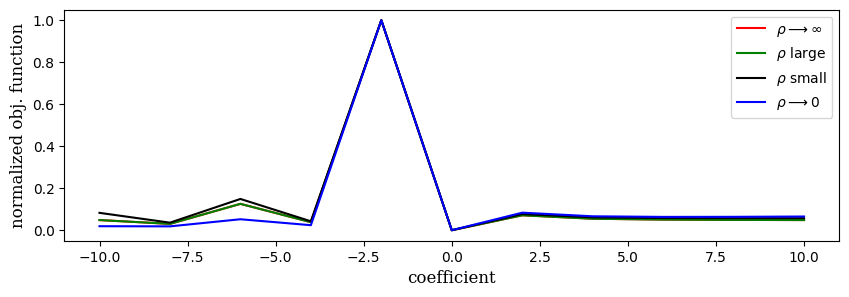

In [12]:
font = FontProperties()
font.set_family('serif')
# font.set_name('Times New Roman')
font.set_size('12')
# font.set_style('italic')

fig, ax =  plt.subplots(figsize=(10, 3))

coeffs = c_all

ax.plot(coeffs, obj_all_inf/np.max(obj_all_inf),color='r',label =  r'$\rho \longrightarrow \infty$')
ax.plot(coeffs, obj_all_large/np.max(obj_all_large),color='g',label = r'$\rho$ large')
ax.plot(coeffs, obj_all_small/np.max(obj_all_small),color='k',label = r'$\rho$ small')
ax.plot(coeffs, obj_all_zero/np.max(obj_all_zero),color='b',label = r'$\rho \longrightarrow 0$')
ax.legend()
ax.set_xlabel('coefficient', fontproperties=font)
ax.set_ylabel('normalized obj. function', fontproperties=font)
# plt.savefig('Poisson2D-full-basis-a-dependent.pdf',bbox_inches='tight')  

## Below is the case for a different inner product (without variable coefficient weight)

In [29]:
# obtain p_i's from f_i's
p_all = []
atrue = (ufl.sin(x[0]*3)**2 + ufl.sin(x[1]*3)**2 + ufl.sin(10*x[0])**2 + ufl.sin(10*x[1])**2 ) 
B = inner(grad(u_trial),grad(u_test))*dx
for i in range(40):
    RHS = f_all[i] * u_test * dx
    problem = LinearProblem(B, RHS, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    u = problem.solve()
    p_all.append(u)

In [30]:

# The bilinear form
# \mathcal{A}_c(u,v)=\int_{\Omega} \nabla u(x)\cdot \nabla v(x)\mathrm{d}x + ...
# \int_{\Omega} c(x)u(x)v(x)\mathrm{d}x - \lambda \int_{\Omega} u(x)v(x)\mathrm{d}x

l = 400
A = inner(grad(u_trial),grad(u_test))*dx + inner(atrue*u_trial,u_test)*dx - inner(l*u_test, u_trial)*dx

D = np.zeros((40,40))
for j in range(40):
    L_true = f_all[j] * u_test * dx
    # solve the forward/state problem to generate synthetic observations
    problem = LinearProblem(A, L_true, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    u_j = problem.solve()
    
    for i in range(40):
        # d_{ij} = \mathcal{P}_i(u_j) = \langle p_i, u_j(\lambda)\rangle_\mathsf{U}
        # The inner product
        # \langle u,v\rangle_{\mathsf{U}} = \int_{\Omega} \nabla u(x)\cdot\nabla v(x)\mathrm{d}x
        #                                    + \int_{\Omega} c(x)u(x)v(x)\mathrm{d}x
        
        D[i,j] = assemble_scalar(form(inner(grad(u_j),grad(p_all[i]))*dx))

In [31]:

A = inner(grad(u_trial),grad(u_test))*dx + inner(atrue*u_trial,u_test)*dx - inner(l*u_test, u_trial)*dx
w_all = [] # initialize {w_i}
G_true = np.zeros((40,40))
for j in range(40):
    L_true = f_all[j] * u_test * dx
    # solve the forward/state problem to generate synthetic observations
    problem = LinearProblem(A, L_true, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    u_j = problem.solve()
    
    w_all.append(u_j)
    for i in range(j+1):
        G_true[i,j] = assemble_scalar(form(inner(grad(w_all[j]),grad(w_all[i]))*dx ))
        G_true[j,i] = G_true[i,j] # since G is symmetric in this case

In [46]:
nk = 51
obj_all_inf = np.zeros(nk,)
obj_all_zero = np.zeros(nk,)
obj_all_small = np.zeros(nk,)
obj_all_large = np.zeros(nk,)
c_all = np.linspace(0, 10, nk)

atrue = (ufl.sin(x[0]*3)**2 + ufl.sin(x[1]*3)**2 + ufl.sin(10*x[0])**2 + ufl.sin(10*x[1])**2 ) 

w_all = []
for k in range(nk):
    # a = interpolate(Expression('8. - 2.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2)) + c', c = k*0.1, degree=5), Va)
    # a = interpolate(Expression('pow(sin(x[0]*3),2) + pow(sin(x[1]*3),2) + (1+c)*(pow(sin(10*x[0]),2) + pow(sin(10*x[1]),2))', 
    #                            c = k*10, degree=2), Va)
    
    # c = (k-(nk-1)/2)*20  
    c = c_all[k]
    a = (1+2*c)*ufl.sin(x[0]*3)**2 + ufl.sin(x[1]*3)**2 + (1+c)*ufl.sin(10*x[0])**2 +(1+c)* ufl.sin(10*x[1])**2 
    
    A = inner(grad(u_trial),grad(u_test))*dx + inner(a*u_trial,u_test)*dx - inner(l*u_test, u_trial)*dx
    
    w_all = [] # initialize {w_i}
    E = np.zeros((40,40))
    G = np.zeros((40,40))
    for j in range(40):
        L_true = f_all[j] * u_test * dx
        # solve the forward/state problem to generate synthetic observations
        problem = LinearProblem(A, L_true, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
        u_j = problem.solve()
        
        w_all.append(u_j)
        for i in range(j+1):
            E[i,j] = D[i,j] - assemble_scalar(form(inner(grad(u_j),grad(p_all[i]))*dx ))
            E[j,i] = E[i,j] # D and E are symmetric as well!
            G[i,j] = assemble_scalar(form(inner(grad(w_all[j]),grad(w_all[i]))*dx))
            G[j,i] = G[i,j] # since G is symmetric in this case
    # np.linalg.cond(G)
    ### J = 0.5*{trace}[E(c)^*(I+1/rho*G(c))^{-1}E(c)]
    # G = G*1e9
    
    G_inv = np.linalg.inv(G)
    
    obj_all_inf[k] =  0.5*np.trace(E.transpose()*E)
    obj_all_large[k] =  0.5*np.trace(E.transpose()* np.linalg.inv(np.eye(40) + G/1e3)*E)
    obj_all_small[k] =  0.5*np.trace(E.transpose()* np.linalg.inv(np.eye(40) + G/1e-3)*E)
    obj_all_zero[k] =  0.5*np.trace(E.transpose()*G_inv*E)

Text(0, 0.5, 'normalized obj. function')

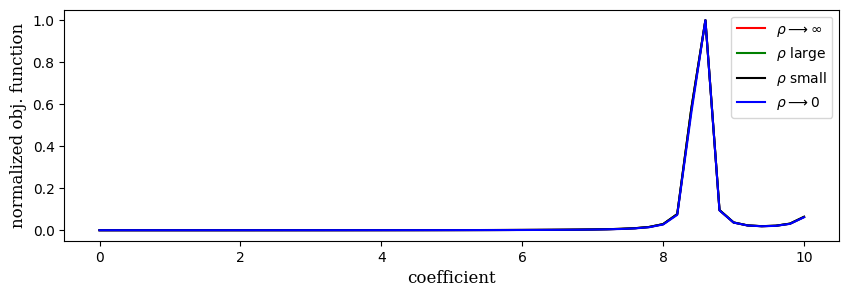

In [47]:
font = FontProperties()
font.set_family('serif')
# font.set_name('Times New Roman')
font.set_size('12')
# font.set_style('italic')

fig, ax =  plt.subplots(figsize=(10, 3))

coeffs = c_all

ax.plot(coeffs, obj_all_inf/np.max(obj_all_inf),color='r',label =  r'$\rho \longrightarrow \infty$')
ax.plot(coeffs, obj_all_large/np.max(obj_all_large),color='g',label = r'$\rho$ large')
ax.plot(coeffs, obj_all_small/np.max(obj_all_small),color='k',label = r'$\rho$ small')
ax.plot(coeffs, obj_all_zero/np.max(obj_all_zero),color='b',label = r'$\rho \longrightarrow 0$')
ax.legend()
ax.set_xlabel('coefficient', fontproperties=font)
ax.set_ylabel('normalized obj. function', fontproperties=font)
# plt.savefig('Poisson2D-full-basis-a-dependent.pdf',bbox_inches='tight')  